In [1]:
import os
import pandas as pd
import janitor
import numpy as np
pd.set_option('display.max_columns', 100)

from utils.utils import change_width, fit_exp, save_mpl_fig
from utils.data_utils import pandas_to_tex
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid', palette='dark') #  Darkgrid Whitegrid Dark White Ticksimport matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
from scipy import stats

DATAPATH = "../data/individual_browsing_data.csv"        
FIGSAVEDIR = "../figs"

df_ind = (pd.read_csv(DATAPATH)
          # Normalize seconds to hours
          .assign(
              duration_adult=lambda df: df.duration_adult/3600,
              duration_nonadult=lambda df: df.duration_nonadult/3600,
          )
         )
df_ind

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,yes_visit_adults,race2,cohort,age,age2,educ2
0,200661421,1963,2,1,4,3,3,1,39,2,D,0.0,1728.0,1728.0,0.000000,0.0,0.000000,21.567222,0.0,1,1960,60,3600,4
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,7.208889,65.054444,1.0,5,1990,31,961,4
2,200953869,1959,2,1,5,2,7,2,42,1,R,0.0,20.0,20.0,0.000000,1.0,0.000000,0.328333,0.0,1,1960,64,4096,4
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,1.712778,6.626389,1.0,2,1970,57,3249,3
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224,0.0,0.118889,106.314722,1.0,4,1980,46,2116,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1802885,1935,1,1,6,4,5,2,12,3,R,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1,1940,88,7744,4
1196,1809723,1943,1,1,2,1,1,1,51,3,D,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,1940,80,6400,2
1197,1827351,1947,1,1,5,3,4,1,31,2,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1950,76,5776,4
1198,1924249,1980,1,7,4,2,7,2,6,4,R,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,5,1980,43,1849,4


### Distribution of visit duration on adult sites

In [2]:
outcome_var = "duration_adult"

In [3]:
# (fold cell) Prep data
qcut_opts = {"q":10, "precision":1, "labels": range(10,101,10), "duplicates": "drop"}

_df = (df_ind
       .query(f"{outcome_var}>0")
       .assign(**{f"decile_{outcome_var}": lambda df: pd.qcut(df[outcome_var], **qcut_opts)})
      )
_df.head(3)

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,yes_visit_adults,race2,cohort,age,age2,educ2,decile_duration_adult
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,7.208889,65.054444,1.0,5,1990,31,961,4,90
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,1.712778,6.626389,1.0,2,1970,57,3249,3,70
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224,0.0,0.118889,106.314722,1.0,4,1980,46,2116,4,30


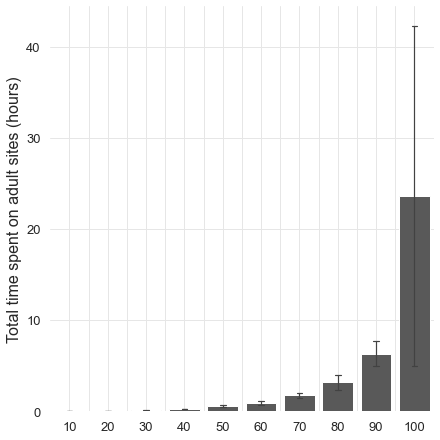

In [4]:
# (fold cell) Plot deciles
scale = .7
fig, ax = plt.subplots(figsize=(9*scale, 9*scale))

sns.barplot(
    x=f"decile_{outcome_var}", y=outcome_var, data=_df, 
    color=".35",
    ci="sd",
    errwidth=1.2,
    capsize=.15,
)
ax.set_yticks(range(0,50,10))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("")
ax.set_ylabel("Total time spent on adult sites (hours)", size=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".9")
ax.yaxis.grid(True, which="both", color=".9")

sns.despine(left=True, bottom=True)
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_duration_on_adultsites"))

In [5]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_deciles = (_df[outcome_var]
               .quantile(ntiles)
               .reset_index()
               .rename_column('index', 'Percentile')
               .assign(**{outcome_var:lambda df: df[outcome_var].apply(int)})
              )
pandas_to_tex(tab_deciles, "../tabs/percentiles_duration_adultsites_by_individuals")
tab_deciles

D:\adult\scripts\utils\data_utils.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=False, header=False)


,Percentile,duration_adult
0,0.00,0
1,0.10,0
2,0.20,0
3,0.30,0
4,0.40,0
5,0.50,0
6,0.60,1
7,0.70,2
8,0.80,4
9,0.90,9


### Distribution of duration on adult sites, by partisanship

In [6]:
# (fold cell) Get deciles mean and std
df_decile_agg = (
    df_ind
    # Make deciles by party
    .query(f"{outcome_var}>0")
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: (
                df.groupby("party")[outcome_var].transform(
                    lambda x: pd.qcut(x, **qcut_opts)
                )
            )
        },
    )
    .groupby(["party", f"decile_{outcome_var}"])[outcome_var]
    .agg(["mean", "std"])
    .reset_index()
    .assign(std=lambda df: df["std"] / 2)
    # Manually "dodge" the points to plot, by party
    .assign(
        **{f"decile_{outcome_var}": lambda df: df[f"decile_{outcome_var}"].astype(int)}
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "D",
                df[f"decile_{outcome_var}"] - 4,
                df[f"decile_{outcome_var}"],
            )
        }
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "R",
                df[f"decile_{outcome_var}"] - 6,
                df[f"decile_{outcome_var}"],
            )
        }
    )
)
df_decile_agg.head(4)

,party,decile_duration_adult,mean,std
0,D,6,0.012750,0.003584
1,D,16,0.040833,0.003936
2,D,26,0.074907,0.006793
3,D,36,0.137006,0.014408


In [7]:
# Prep data for scatter
df_visits = (
    df_ind.dropna(subset="party").query(f"{outcome_var}>0")
    # Retrieve quantiles of visits to adult sites
    .case_when(
        # when R, D, or I
        lambda df: df.party == "R",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='R'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "D",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='D'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "I",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='I'")[outcome_var].sort_values(), x
            )
        ),
        # else nan
        np.nan,
        column_name=f"quantiles_{outcome_var}",
    )
)
df_visits.head(3)

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,yes_visit_adults,race2,cohort,age,age2,educ2,quantiles_duration_adult
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224,0.0,0.118889,106.314722,1.0,4,1980,46,2116,4,34.782609
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,NaN,8.751667,114.302778,1.0,3,2000,27,729,4,85.714286
20,204288513,1991,1,1,2,3,4,2,54,3,I,38.0,79884.0,79922.0,0.047546,NaN,0.100000,219.466389,1.0,1,1990,32,1024,2,14.285714


In [8]:
# (fold cell) Standard Options
palette = {"R": "Maroon", "D": "Navy"}
errorlinestyle = {"R": "-.", "D": "-"}

running_var = f"quantiles_{outcome_var}"

scatter_opts = {
    "x": running_var, 
    "y": outcome_var,
    "marker":"x",
    "s":30,
    "linewidths":.8,
    "alpha":.4,
}

errorbar_opts = {
    "x":f"decile_{outcome_var}",
    "y":"mean",
    "yerr":"std",
    "elinewidth":2.5,
    "ls":"none",
    "alpha":.6,
    "zorder":1,    
}
scatter_decile_opts = {
    "x":f"decile_{outcome_var}", 
    "y":"mean",
    "marker":"o",
    "s":60,
    "alpha":.85,
}
line_opts = {
    "lw":1.5,
    "alpha":0.5,
}

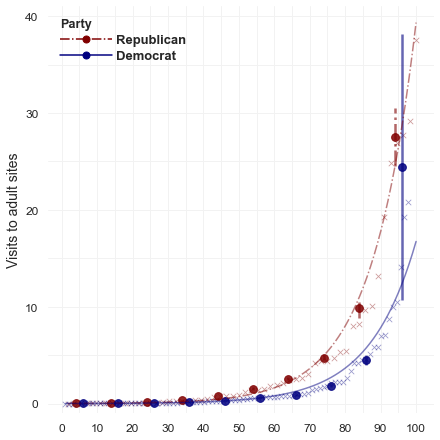

In [9]:
# (fold cell) Plot splits by party
scale = .7
fig, ax = plt.subplots(figsize=(9*scale, 9*scale))

# Scatterpoints for individuals
for party in ["R", "D"]:
    plt.scatter(
        data=df_visits.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_opts
    )
# Error bars
for party in ["R", "D"]:
    eb = plt.errorbar(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **errorbar_opts,
    )
    if party == "R":
        eb[-1][0].set_linestyle(errorlinestyle["R"])

# Scatter for the 2 parties x 10 deciles
for party in ["R", "D"]:
    plt.scatter(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_decile_opts
    )

# Connect deciles
for party in ["R", "D"]:
    y = df_visits.query(f"party=='{party}'")[outcome_var]
    x = df_visits.query(f"party=='{party}'")[running_var]
    x_fitted, y_fitted = fit_exp(x,y)
    plt.plot(x_fitted, y_fitted, color=palette[party], linestyle=errorlinestyle[party], **line_opts)

# Figure settings
ax.set_xticks(range(0,110,10))
ax.set_xlabel("")
ax.set_ylabel("Visits to adult sites", size=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticks(range(0,50,10))
ax.set_ylim(-1, 41)

# Grids
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".95")
ax.yaxis.grid(True, which="both", color=".95")

# Custom Legend
rep_hand = mlines.Line2D([], [], 
                         color='maroon', marker='o', ls="-.",
                         markersize=7, label='Republican'
                        )
dem_hand = mlines.Line2D([], [], 
                         color='navy', marker='o', ls="-",
                         markersize=7, label='Democrat',
                        )
custom_legend = plt.legend(
    handles=[rep_hand, dem_hand], 
    handlelength=4, 
    handletextpad=.3,
    labelspacing=.3,
    title="Party", 
    frameon=False,
    prop={'weight':'bold', "size":13},
#     title_fontproperties={'weight':'bold', 'size':14},
)
custom_legend._legend_box.align = "left"
custom_legend.get_title().set_weight("bold")

sns.despine(left=True,bottom=True)
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_duration_on_adultsites_by_party"))

### Distribution of proportion of visits to adult sites

In [10]:
# (fold cell) Prep data
qcut_opts = {"q":10, "precision":1, "labels": range(10,101,10), "duplicates": "drop"}

_df = (df_ind
       .query("prop_adult_visits>0")
       .assign(decile_prop_adult=lambda df: pd.qcut(df.prop_adult_visits, **qcut_opts))
      )
_df.head(3)

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,yes_visit_adults,race2,cohort,age,age2,educ2,decile_prop_adult
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,7.208889,65.054444,1.0,5,1990,31,961,4,70
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,1.712778,6.626389,1.0,2,1970,57,3249,3,60
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224,0.0,0.118889,106.314722,1.0,4,1980,46,2116,4,20


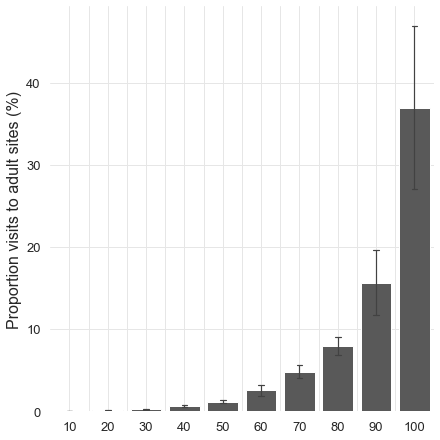

In [11]:
# (fold cell) Plot deciles
scale = .7
fig, ax = plt.subplots(figsize=(9*scale, 9*scale))

sns.barplot(
    x="decile_prop_adult", y="prop_adult_visits", data=_df, 
    color=".35",
    ci="sd",
    errwidth=1.2,
    capsize=.15,
)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("")
ax.set_ylabel("Proportion visits to adult sites (%)", size=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".9")
ax.yaxis.grid(True, which="both", color=".9")

sns.despine(left=True, bottom=True)
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_proportion_adultsites_duration"))

In [12]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_deciles = (_df
               .prop_adult_visits.quantile(ntiles)
               .reset_index()
               .rename_column('index', 'Percentile')
               .round(decimals=1)
              )
pandas_to_tex(tab_deciles, "../tabs/percentiles_proportion_adultsites_duration_by_individuals")
tab_deciles

D:\adult\scripts\utils\data_utils.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=False, header=False)


,Percentile,prop_adult_visits
0,0.0,0.0
1,0.1,0.1
2,0.2,0.1
3,0.3,0.4
4,0.4,0.9
5,0.5,1.5
6,0.6,3.7
7,0.7,6.3
8,0.8,10.0
9,0.9,23.8


### Distribution of proportion of visits to adult sites, by partisanship

In [13]:
outcome_var = "prop_adult_visits"

In [14]:
# (fold cell) Get deciles mean and std
df_decile_agg = (
    df_ind
    # Make deciles by party
    .query(f"{outcome_var}>0")
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: (
                df.groupby("party")[outcome_var].transform(
                    lambda x: pd.qcut(x, **qcut_opts)
                )
            )
        },
    )
    .groupby(["party", f"decile_{outcome_var}"])[outcome_var]
    .agg(["mean", "std"])
    .reset_index()
    .assign(std=lambda df: df["std"] / 2)
    # Manually "dodge" the points to plot, by party
    .assign(
        **{f"decile_{outcome_var}": lambda df: df[f"decile_{outcome_var}"].astype(int)}
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "D",
                df[f"decile_{outcome_var}"] - 4,
                df[f"decile_{outcome_var}"],
            )
        }
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "R",
                df[f"decile_{outcome_var}"] - 6,
                df[f"decile_{outcome_var}"],
            )
        }
    )
)
df_decile_agg.head(4)

,party,decile_prop_adult_visits,mean,std
0,D,6,0.034682,0.010060
1,D,16,0.095043,0.008524
2,D,26,0.212646,0.029667
3,D,36,0.433074,0.042815


In [15]:
# Prep data for scatter
df_visits = (
    df_ind.dropna(subset="party").query(f"{outcome_var}>0")
    # Retrieve quantiles of visits to adult sites
    .case_when(
        # when R, D, or I
        lambda df: df.party == "R",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='R'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "D",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='D'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "I",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='I'")[outcome_var].sort_values(), x
            )
        ),
        # else nan
        np.nan,
        column_name=f"quantiles_{outcome_var}",
    )
)
df_visits.head(3)

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,yes_visit_adults,race2,cohort,age,age2,educ2,quantiles_prop_adult_visits
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224,0.0,0.118889,106.314722,1.0,4,1980,46,2116,4,17.204301
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,NaN,8.751667,114.302778,1.0,3,2000,27,729,4,63.888889
20,204288513,1991,1,1,2,3,4,2,54,3,I,38.0,79884.0,79922.0,0.047546,NaN,0.100000,219.466389,1.0,1,1990,32,1024,2,2.777778


In [16]:
# (fold cell) Standard Options
palette = {"R": "Maroon", "D": "Navy"}
errorlinestyle = {"R": "-.", "D": "-"}

running_var = f"quantiles_{outcome_var}"

scatter_opts = {
    "x": running_var, 
    "y": outcome_var,
    "marker":"x",
    "s":30,
    "linewidths":.8,
    "alpha":.4,
}

errorbar_opts = {
    "x":f"decile_{outcome_var}",
    "y":"mean",
    "yerr":"std",
    "elinewidth":2.5,
    "ls":"none",
    "alpha":.6,
    "zorder":1,    
}
scatter_decile_opts = {
    "x":f"decile_{outcome_var}", 
    "y":"mean",
    "marker":"o",
    "s":60,
    "alpha":.85,
}
line_opts = {
    "lw":1.5,
    "alpha":0.5,
}

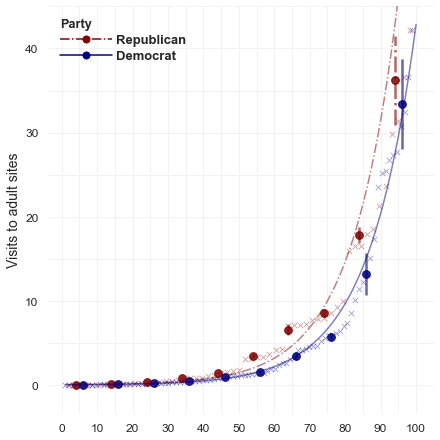

In [17]:
# (fold cell) Plot splits by party
scale = .7
fig, ax = plt.subplots(figsize=(9*scale, 9*scale))

# Scatterpoints for individuals
for party in ["R", "D"]:
    plt.scatter(
        data=df_visits.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_opts
    )
# Error bars
for party in ["R", "D"]:
    eb = plt.errorbar(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **errorbar_opts,
    )
    if party == "R":
        eb[-1][0].set_linestyle(errorlinestyle["R"])

# Scatter for the 2 parties x 10 deciles
for party in ["R", "D"]:
    plt.scatter(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_decile_opts
    )

# Connect deciles
for party in ["R", "D"]:
    y = df_visits.query(f"party=='{party}'")[outcome_var]
    x = df_visits.query(f"party=='{party}'")[running_var]
    x_fitted, y_fitted = fit_exp(x,y)
    plt.plot(x_fitted, y_fitted, color=palette[party], linestyle=errorlinestyle[party], **line_opts)

# Figure settings
ax.set_xticks(range(0,110,10))
ax.set_xlabel("")
ax.set_ylabel("Visits to adult sites", size=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticks(range(0,50,10))
ax.set_ylim(ax.get_ylim()[0], 45)

# Grids
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".95")
ax.yaxis.grid(True, which="both", color=".95")

# Custom Legend
rep_hand = mlines.Line2D([], [], 
                         color='maroon', marker='o', ls="-.",
                         markersize=7, label='Republican'
                        )
dem_hand = mlines.Line2D([], [], 
                         color='navy', marker='o', ls="-",
                         markersize=7, label='Democrat',
                        )
custom_legend = plt.legend(
    handles=[rep_hand, dem_hand], 
    handlelength=4, 
    handletextpad=.3,
    labelspacing=.3,
    title="Party", 
    frameon=False,
    prop={'weight':'bold', "size":13},
#     title_fontproperties={'weight':'bold', 'size':14},
)
custom_legend._legend_box.align = "left"
custom_legend.get_title().set_weight("bold")

sns.despine(left=True,bottom=True)
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_proportion_adultsites_duration_by_party"))

In [18]:
# (fold cell) Get table of percentiles
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
_var = "prop_adult_visits"
_party = "R"
_tab_R = (df_ind
          .query(f"party=='{_party}'")
          [_var].quantile(ntiles)
          .reset_index()
          .rename_column('index', 'Percentile')
          .rename_column(_var, f'{_var}_{_party}')
         )

_party = "D"
_tab_D = (df_ind
          .query(f"party=='{_party}'")
          [_var].quantile(ntiles)
          .reset_index()
          .rename_column('index', 'Percentile')
          .rename_column(_var, f'{_var}_{_party}')
         )

tab_perc = (_tab_R
            .merge(_tab_D, on="Percentile", how="left", validate="1:1")
            .assign(
                prop_adult_visits_R=lambda df: df.prop_adult_visits_R.map('{:,.1f}'.format),
                prop_adult_visits_D=lambda df: df.prop_adult_visits_D.map('{:,.1f}'.format), 
            )                 
           )
pandas_to_tex(tab_perc, "../tabs/percentiles_proportion_adultsites_duration_by_individuals_by_party")
tab_perc

D:\adult\scripts\utils\data_utils.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=False, header=False)


,Percentile,prop_adult_visits_R,prop_adult_visits_D
0,0.00,0.0,0.0
1,0.10,0.0,0.0
2,0.20,0.0,0.0
3,0.30,0.0,0.0
4,0.40,0.0,0.0
5,0.50,0.0,0.0
6,0.60,0.0,0.0
7,0.70,0.0,0.2
8,0.80,0.8,1.1
9,0.90,7.1,5.9
